# Model Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import gensim.utils
import pickle
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import save_model
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import History
from tensorflow.keras.utils import to_categorical
import re

***Data Imports and Function Definitions***

In [2]:
# importing all possible training datasets - only subj_obj and uci_combined were used

bbc1000 = pd.read_csv('../data/train_data/sentiment/6_human_coded_datasets_good/bbc_formatted.csv')
news_articles = pd.read_csv('../data/train_data/sentiment/news_articles/news_formatted.csv')
imdb = pd.read_csv('../data/train_data/sentiment/IMDB_good/imdb_formatted.csv')
ideological = pd.read_csv('../data/train_data/ideology/IBC/ideological_formatted.csv')
subj_obj = pd.read_csv('../data/train_data/subjectivity/subj_obj_formatted.csv')
uci_combined = pd.read_csv('../data/train_data/sentiment/UCI/uci_combined.csv')

In [3]:
# defining stop words

stop_words = set([x.lower() for x in stopwords.words('english')])

In [4]:
# defining preprocessing function

def preprocess(data, stem_data, remove_stopwords):
    processed = []
    stemmer = PorterStemmer()
    for file in data:
        
        # lowercasing all text
        file = file.lower()
        
        # removing non-alpha characters
        file = re.sub('[^a-zA-Z]', ' ', file)
        
        # tokenizing articles
        tokenized = word_tokenize(file)
        
        # removing stop words from tokens
        stop_removed_tokens = []
        if remove_stopwords:
            for word in tokenized:
                if word not in stop_words:
                    stop_removed_tokens.append(word)
        else:
            stop_removed_tokens = tokenized
        if stem_data:
            stemmed = []
            for token in stop_removed_tokens:
                stemmed.append(stemmer.stem(token))
            processed.append(stemmed)
        else:
            processed.append(stop_removed_tokens)
    return processed

In [5]:
# defining model evaluation graphs function

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## Sentiment Analysis

In [6]:
# sentiment analysis parameters

vocab_size_sent = 5000
embedding_dimension_sent = 10
max_length_sent = 1000
trunc_type_sent = 'post'
padding_type_sent = 'post'
oov_tok_sent = '<OOV>'

In [7]:
# preprocessing texts

uci_combined['processed_no_stem'] = preprocess(uci_combined['text'], stem_data = False, remove_stopwords = False)

In [8]:
# creating X, y variables and splitting to train/test sets

sent_texts = uci_combined['processed_no_stem']
sent_labels = uci_combined['is_positive']

In [9]:
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(sent_texts, sent_labels, test_size = 0.25, stratify = sent_labels)

In [10]:
# converting target variables to numpy arrays

y_train_sent = np.array(y_train_sent)
y_test_sent = np.array(y_test_sent)

In [11]:
# Checking splits

print(f"Total documents: {len(sent_texts)}")
print(f"Train Documents: {len(X_train_sent)}")
print(f"Test Documents: {len(y_train_sent)}")
print(f"Train Labels: {len(X_test_sent)}")
print(f"Test Labels: {len(y_test_sent)}")

Total documents: 2748
Train Documents: 2061
Test Documents: 2061
Train Labels: 687
Test Labels: 687


In [12]:
# creating a fitting a tokenizer on training set and checking frequent items

tokenizer_sent = Tokenizer(num_words = vocab_size_sent, oov_token = oov_tok_sent)
tokenizer_sent.fit_on_texts(X_train_sent)
word_index = tokenizer_sent.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'i': 4,
 'a': 5,
 'it': 6,
 'is': 7,
 'to': 8,
 'this': 9,
 'of': 10}

In [13]:
# converting text data to sequence data

train_sequences_sent = tokenizer_sent.texts_to_sequences(X_train_sent)

In [14]:
# padding sentences

train_padded_sent = pad_sequences(train_sequences_sent, maxlen=max_length_sent, padding=padding_type_sent, truncating=trunc_type_sent)

In [15]:
# Checking for consistent column lengths

print(len(train_sequences_sent[0]))
print(len(train_padded_sent[0]))

print(len(train_sequences_sent[1]))
print(len(train_padded_sent[1]))

print(len(train_sequences_sent[10]))
print(len(train_padded_sent[10]))

6
1000
9
1000
10
1000


In [16]:
# serializing/padding test data

test_sequences_sent = tokenizer_sent.texts_to_sequences(X_test_sent)
test_padded_sent = pad_sequences(test_sequences_sent, maxlen=max_length_sent, padding=padding_type_sent, truncating=trunc_type_sent)

In [17]:
test_padded_sent.shape

(687, 1000)

In [23]:
# Building / compiling / fitting LSTM model


model_sent = Sequential()

model_sent.add(Embedding(vocab_size_sent, 
                         embedding_dimension_sent))

model_sent.add(Dropout(0.7))

model_sent.add(Bidirectional(LSTM(embedding_dimension_sent)))

model_sent.add(Dropout(0.7))


model_sent.add(Dense(1, activation = 'sigmoid'))

In [24]:
model_sent.compile(loss='binary_crossentropy', 
                       optimizer = 'adam', 
                       metrics = ['accuracy'],
                      )

In [25]:
print(type(train_padded_sent))
print(type(y_train_sent))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [26]:
callbacks_sent = [History()]

In [27]:
model_sent.fit(train_padded_sent, y_train_sent,
                                     epochs = 8,
                                     callbacks = callbacks_sent,
                                     validation_data = (test_padded_sent, y_test_sent))

Train on 2061 samples, validate on 687 samples
Epoch 1/8
2061/2061 [==============================] - 35s 17ms/sample - loss: 0.6926 - accuracy: 0.4988 - val_loss: 0.6913 - val_accuracy: 0.5255
Epoch 2/8
2061/2061 [==============================] - 33s 16ms/sample - loss: 0.6891 - accuracy: 0.5279 - val_loss: 0.6876 - val_accuracy: 0.5153
Epoch 3/8
2061/2061 [==============================] - 33s 16ms/sample - loss: 0.6799 - accuracy: 0.6084 - val_loss: 0.6694 - val_accuracy: 0.6827
Epoch 4/8
2061/2061 [==============================] - 31s 15ms/sample - loss: 0.6429 - accuracy: 0.6982 - val_loss: 0.6240 - val_accuracy: 0.7482
Epoch 5/8
2061/2061 [==============================] - 31s 15ms/sample - loss: 0.5858 - accuracy: 0.7734 - val_loss: 0.5825 - val_accuracy: 0.7482
Epoch 6/8
2061/2061 [==============================] - 31s 15ms/sample - loss: 0.5236 - accuracy: 0.7933 - val_loss: 0.5117 - val_accuracy: 0.7933
Epoch 7/8
2061/2061 [==============================] - 31s 15ms/sample 

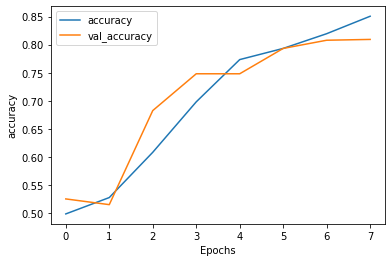

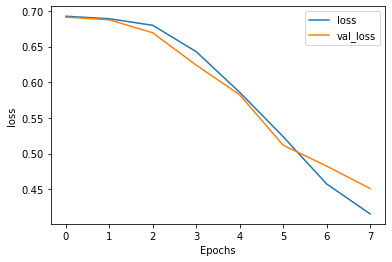

In [28]:
# visualizing accuracy and loss functions over training epochs

plot_graphs(model_sent.history, "accuracy")
plot_graphs(model_sent.history, "loss")

In [29]:
# saving model and pickled tokenizer for predictions

save_model(model_sent, '../data/train_data/sentiment/sent_model.h5')


with open('../data/train_data/sentiment/tokenizer_sent.pickle', 'wb') as handle:
    pickle.dump(tokenizer_sent, handle, protocol = pickle.HIGHEST_PROTOCOL)

## Subjectivity Analysis

In [66]:
# setting subjectivity parameters

vocab_size_subj_obj = 5000
embedding_dimension_subj_obj = 8
max_length_subj_obj = 200
trunc_type_subj_obj = 'post'
padding_type_subj_obj = 'post'
oov_tok_subj_obj = '<OOV>'

In [31]:
# processing text data for modeling

subj_obj['processed_stem'] = preprocess(subj_obj['text'], stem_data = True, remove_stopwords = False)

In [32]:
subj_obj['processed_no_stem'] = preprocess(subj_obj['text'], stem_data = False, remove_stopwords = False)

In [33]:
subj_obj.head(2)

,text,is_subjective,processed_stem,processed_no_stem
0,"smart and alert , thirteen conversations about...",1,"[smart, and, alert, thirteen, convers, about, ...","[smart, and, alert, thirteen, conversations, a..."
1,"color , musical bounce and warm seas lapping o...",1,"[color, music, bounc, and, warm, sea, lap, on,...","[color, musical, bounce, and, warm, seas, lapp..."


In [34]:
# Splitting into feature and target sets and splitting into training and testing

subj_obj_texts = subj_obj['processed_no_stem']
subj_obj_labels = subj_obj['is_subjective']

In [35]:
X_train_subj_obj, X_test_subj_obj, y_train_subj_obj, y_test_subj_obj = train_test_split(subj_obj_texts, subj_obj_labels, test_size = 0.25, stratify = subj_obj_labels)

In [36]:
# converting labels to numpy arrays

y_train_subj_obj = np.array(y_train_subj_obj)
y_test_subj_obj = np.array(y_test_subj_obj)

In [37]:
# checking splits

print(f"Total documents: {len(subj_obj_texts)}")
print(f"Train Documents: {len(X_train_subj_obj)}")
print(f"Test Documents: {len(y_train_subj_obj)}")
print(f"Train Labels: {len(X_test_subj_obj)}")
print(f"Test Labels: {len(y_test_subj_obj)}")

Total documents: 10000
Train Documents: 7500
Test Documents: 7500
Train Labels: 2500
Test Labels: 2500


In [38]:
# Fitting tokenizer and checking frequent words

tokenizer_subj_obj = Tokenizer(num_words = vocab_size_subj_obj, oov_token = oov_tok_subj_obj)
tokenizer_subj_obj.fit_on_texts(X_train_subj_obj)
word_index = tokenizer_subj_obj.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'the': 2,
 'a': 3,
 'and': 4,
 'of': 5,
 'to': 6,
 'in': 7,
 'is': 8,
 's': 9,
 'it': 10}

In [39]:
# serializing and padding train sequences

train_sequences_subj_obj = tokenizer_subj_obj.texts_to_sequences(X_train_subj_obj)
print(train_sequences_subj_obj[10])

[4893, 8, 4894, 1, 15, 11, 17, 19, 3288, 12, 663, 540, 411, 5, 2, 120, 9, 541]


In [40]:
train_padded_subj_obj = pad_sequences(train_sequences_subj_obj, maxlen=max_length_subj_obj, padding=padding_type_subj_obj, truncating=trunc_type_subj_obj)

In [41]:
# checking padding

print(len(train_sequences_subj_obj[0]))
print(len(train_padded_subj_obj[0]))

print(len(train_sequences_subj_obj[1]))
print(len(train_padded_subj_obj[1]))

print(len(train_sequences_subj_obj[10]))
print(len(train_padded_subj_obj[10]))

19
200
30
200
18
200


In [42]:
# checking article length distribution

art_lengths_subj_obj = []
for sequence in train_sequences_subj_obj:
    art_lengths_subj_obj.append(len(sequence))

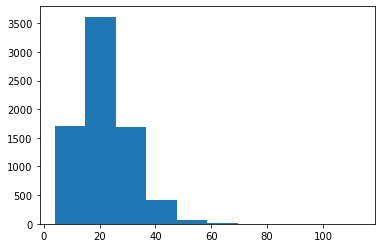

In [43]:
plt.hist(art_lengths_subj_obj);

In [44]:
# serializing and padding test sequences

test_sequences_subj_obj = tokenizer_subj_obj.texts_to_sequences(X_test_subj_obj)
test_padded_subj_obj = pad_sequences(test_sequences_subj_obj, maxlen=max_length_subj_obj, padding=padding_type_subj_obj, truncating=trunc_type_subj_obj)

print(len(test_sequences_subj_obj))
print(test_padded_subj_obj.shape)

2500
(2500, 200)


In [67]:
# Building / compiling / fitting LSTM model

model_subj_obj = Sequential()

model_subj_obj.add(Embedding(vocab_size_subj_obj, embedding_dimension_subj_obj))

model_subj_obj.add(Bidirectional(LSTM(embedding_dimension_subj_obj)))

model_subj_obj.add(Dropout(0.7))

model_subj_obj.add(Dense(embedding_dimension_subj_obj, activation = 'relu'))

model_subj_obj.add(Dropout(0.7))

model_subj_obj.add(Dense(embedding_dimension_subj_obj, activation = 'relu'))

model_subj_obj.add(Dense(1, activation = 'sigmoid'))

In [68]:
model_subj_obj.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 8)           40000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 16)                1088      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_11 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [69]:
model_subj_obj.compile(loss='binary_crossentropy', 
                       optimizer = 'adam', 
                       metrics = ['accuracy'],
                      )

In [70]:
type(train_padded_subj_obj)

numpy.ndarray

In [71]:
type(y_train_subj_obj)

numpy.ndarray

In [72]:
callbacks_subj_obj = [History()]

In [73]:
model_subj_obj.fit(train_padded_subj_obj, y_train_subj_obj,
                                     epochs = 6,
                                     callbacks = callbacks_subj_obj,
                                     validation_data = (test_padded_subj_obj, y_test_subj_obj))

Train on 7500 samples, validate on 2500 samples
Epoch 1/6
7500/7500 [==============================] - 25s 3ms/sample - loss: 0.6926 - accuracy: 0.4945 - val_loss: 0.6858 - val_accuracy: 0.5480
Epoch 2/6
7500/7500 [==============================] - 21s 3ms/sample - loss: 0.5851 - accuracy: 0.6877 - val_loss: 0.3934 - val_accuracy: 0.8744
Epoch 3/6
7500/7500 [==============================] - 21s 3ms/sample - loss: 0.4579 - accuracy: 0.7903 - val_loss: 0.2792 - val_accuracy: 0.9052
Epoch 4/6
7500/7500 [==============================] - 21s 3ms/sample - loss: 0.3919 - accuracy: 0.8221 - val_loss: 0.2544 - val_accuracy: 0.9100
Epoch 5/6
7500/7500 [==============================] - 21s 3ms/sample - loss: 0.3393 - accuracy: 0.8564 - val_loss: 0.2623 - val_accuracy: 0.9020
Epoch 6/6
7500/7500 [==============================] - 21s 3ms/sample - loss: 0.2966 - accuracy: 0.8749 - val_loss: 0.2769 - val_accuracy: 0.8860


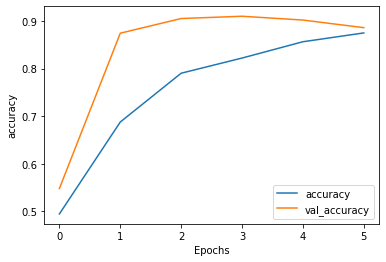

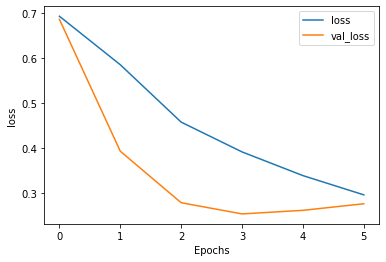

In [74]:
# viewing accuracy and loss over epochs

plot_graphs(model_subj_obj.history, "accuracy")
plot_graphs(model_subj_obj.history, "loss")

In [75]:
# saving model and pickled tokenizer

save_model(model_subj_obj, '../data/train_data/subjectivity/subj_obj_model.h5')

with open('../data/train_data/subjectivity/tokenizer_subj_obj.pickle', 'wb') as handle:
    pickle.dump(tokenizer_subj_obj, handle, protocol = pickle.HIGHEST_PROTOCOL)